In [1]:
#!pip uninstall statsmodels
#!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from os import listdir
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

# Implementation of LSTM
## Variables to Consider
<ul>
    <li>Hidden Parameters</li>
    <li>Learning Rate (smaller learning rate requires more epoches to achieve similar results)</li>
    <li>Size of input sequence</li>
    <li>Size of prediction</li>
    <li>Hidden Layers (Different Notebook)</li>
</ul>

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using cuda")

using cuda


Following Code Adapted from ([github sample](https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb))

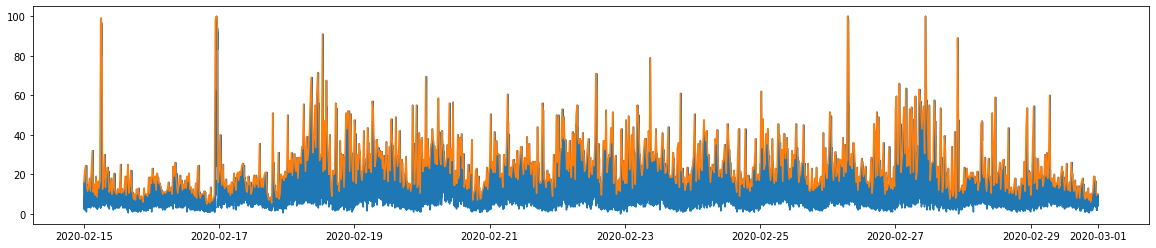

(1080, 1)


In [15]:
def readData(file='samples/WY.csv', freq=20):
    """
    data = pd.read_csv(file, delimiter=',', index_col=0, parse_dates=True)
    plt.plot(data)
    ts = data.iloc[:,0:1].values
    print(ts.shape)
    return ts
    """
    data = pd.read_csv(file, delimiter=',', index_col=0, parse_dates=True)
    plt.figure(figsize=(20, 4))
    plt.plot(data)
    data = data.resample(str(freq) + 'T').max()
    raw_values = np.asarray(data['CpuUtilizationAverage']).reshape(data.shape[0], 1)
    plt.plot(data)
    #plt.savefig("data_plots/{}.png".format(file.replace(".csv", "").replace("samples/", "")))
    plt.show()
    return raw_values

training_set = readData()
print(training_set.shape)

In [15]:
def large_sliding_windows(data, seq_length, pred_length=2):
    x = []
    y = []

    for i in range(len(data)-seq_length-pred_length+1):
        _x = data[i:(i+seq_length)]
        _y = np.stack(data[i+seq_length:i+seq_length+pred_length], axis=1)[0]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

def genData(training_set):
    sc = MinMaxScaler()
    training_data = sc.fit_transform(training_set) # normalizes the data

    seq_length = 4 # seems arbitrary
    pred_seq_len = 1
    x, y = large_sliding_windows(training_data, seq_length, pred_seq_len)

    train_size = int(len(y) * 0.67)
    test_size = len(y) - train_size

    dataX = Variable(torch.Tensor(np.array(x))).to(device)
    dataY = Variable(torch.Tensor(np.array(y))).to(device)

    trainX = Variable(torch.Tensor(np.array(x[0:train_size]))).to(device)
    trainY = Variable(torch.Tensor(np.array(y[0:train_size]))).to(device)

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
    
    #print(trainX.shape)
    #print(trainY.shape)
    #print(testX.shape)
    #print(testY.shape)
    return ((dataX, dataY), (trainX, trainY), (testX, testY), train_size, sc)
    
    
(dataX, dataY), (trainX, trainY), (testX, testY), train_size, sc = genData(training_set)
print(trainY.shape)

torch.Size([14468, 2])


In [5]:
## Generate Naive Examples
def getNaive(trainY, testY, testX):
    mean = trainY.mean()
    mean_forecasts = np.full(testY.shape, mean.item())
    naive_forecasts = np.full(testY.shape, trainX[-1][-1].item())  # always predicts last provided
    four_naive_forecasts = np.ones(testY.shape) * testX[:, -1].numpy()
    four_mean_forecasts = np.ones(testY.shape) * np.mean(testX.numpy(), axis=1)

    #naive_forecasts = naive_forecasts.reshape(-1, 1)
    #mean_forecasts = mean_forecasts.reshape(-1, 1)

    denormalize=False

    if denormalize:
        naive_forecasts = sc.inverse_transform(naive_forecasts)
        mean_forecasts = sc.inverse_transform(mean_forecasts)
        four_naive_forecasts = sc.inverse_transform(four_naive_forecasts)
        four_mean_forecasts = sc.inverse_transform(four_mean_forecasts)
    return (naive_forecasts, mean_forecasts, four_naive_forecasts, four_mean_forecasts)
    
naive_forecasts, mean_forecasts, four_naive_forecasts, four_mean_forecasts = getNaive(trainY, testY, testX)


In [23]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        #print(h_0.shape)
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out.to(device)
        
        return out

Training
Revisit SO Post (https://stackoverflow.com/questions/48274929/pytorch-runtimeerror-trying-to-backward-through-the-graph-a-second-time-but)

In [24]:
def train(trainX, trainY, pred_seq_len=2, seq_length=4):
    num_epochs = 100 # seems to stabilize here, higher and it seems to overfit
    learning_rate = 0.01

    hidden_size = 10 # hyper parameter
    
    input_size = 1 # required for this time series (value)
    num_layers = 1 # hyper parameter

    lstm = LSTM(pred_seq_len, input_size, hidden_size, num_layers, seq_length)
    lstm.to(device)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    #criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad() # remove stored gradient

        # obtain the loss function
        loss = criterion(outputs, trainY) #.squeeze()
        #print(outputs)

        loss.backward()

        optimizer.step()
        if epoch % 10 == 0:
            pass #print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    return lstm

lstm = train(trainX, trainY)

torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
torch.Size([1, 14468, 10])
t

Testing

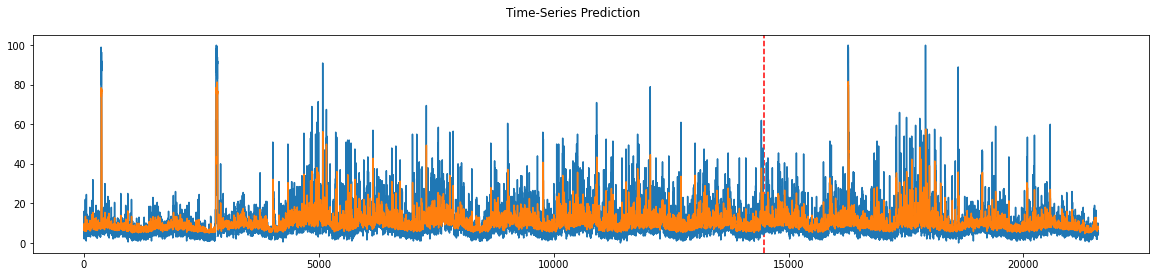

In [8]:
def test(lstm, dataX, dataY, train_size, sc):
    lstm.eval()
    train_predict = lstm(dataX)

    data_predict = train_predict.data.cpu().numpy()
    dataY_plot = dataY.data.cpu().numpy()

    data_predict_transform = sc.inverse_transform(data_predict)
    dataY_plot_transform = sc.inverse_transform(dataY_plot)

    plt.figure(figsize=(20, 4))
    plt.axvline(x=train_size, c='r', linestyle='--') # data shift from train to test

    plt.plot(dataY_plot_transform[:])
    plt.plot(data_predict_transform[:])
    plt.suptitle('Time-Series Prediction')
    plt.show()

    #print(data_predict_transform)
    #print(dataY_plot_transform)
    return (data_predict, dataY_plot)

data_predict, dataY_plot = test(lstm, dataX, dataY, train_size, sc)

Image is deceptive. Try ~100 samples to see a closer fit

Accuracy Calculations

In [9]:
#print(data_predict.shape)
#print(dataY_plot.shape)
_preds = data_predict[train_size:]
_labels = dataY_plot[train_size:]


mean_err = np.sum(np.absolute(_preds-_labels)) / _preds.shape[0]
print("Mean Error - {}".format(mean_err)) # average difference from true
brier_score = np.sum(np.power(_preds-_labels, 2)) / _preds.shape[0]
print("Mean Square Error - {}".format(brier_score))

Mean Error - 0.04122790779123404
Mean Square Error - 0.00432121701840684


In [10]:
eps = 1e-5
# Mean Average Percent Error
def mape(preds, labels):
    err = 0
    for (pred, label) in zip(preds, labels):
        denum = np.absolute(label) if label !=0 else 1 # this might be wrong
        err += (np.absolute(pred-label) / denum)
    err /= preds.shape[0]
    print("MAPE - {}".format(err[0]))
    return err
    
# Brier Score or Mean Squared Error
def mse(preds, labels):
    err = np.sum(np.power(preds-labels, 2)) / preds.shape[0]
    print("MSE - {}".format(err))
    return err
    
# Root Mean Squared Error
def rmse(preds, labels):
    err = np.power(mse(preds, labels), 0.5)
    print("RMSE - {}".format(err))
    return err

# Symmetric Mean Absolute Percentage Error
# some issues in bias, but commonly used
def smape(preds, labels):
    err = 0
    for (pred, label) in zip(preds, labels):
        denum = np.absolute(pred)+np.absolute(label) if np.absolute(pred)+np.absolute(label) !=0 else 1 #check!!
        err += (np.absolute(pred-label) / denum)
    err /= preds.shape[0] # in textbook, also multiply by 200 but this might be for percentage?
    print("SMAPE - {}".format(err[0]))
    return err

errors = [mape, mse, rmse, smape]

def print_errors(preds, labels):
    for error in errors:
        error(preds, labels)
    
def old_print_error(preds, labels):
    mean_err = np.sum(np.absolute(preds-labels)) / preds.shape[0]
    print("Mean Error - {}".format(mean_err)) # average difference from true
    brier_score = np.sum(np.power(preds-labels, 2)) / preds.shape[0]
    print("Mean Square Error - {}".format(brier_score))
    
def printErrors(data_predict, dataY_plot, train_size, naive_forecasts, mean_forecasts, four_mean_forecasts, four_naive_forecasts):
    forecasts = data_predict[train_size:]
    test = dataY_plot[train_size:]
    print("LSTM PREDICTIONS")
    old_print_error(forecasts, test)

    print("\nNAIVE PREDICTIONS")
    old_print_error(naive_forecasts, test)
    print("\nMEAN PREDICTIONS")
    old_print_error(mean_forecasts, test)
    print("\nFOUR NAIVE PREDICTIONS")
    old_print_error(four_mean_forecasts, test)
    print("\nFOUR MEAN PREDICTIONS")
    old_print_error(four_naive_forecasts, test)
    
printErrors(data_predict, dataY_plot, train_size, naive_forecasts, mean_forecasts, four_mean_forecasts, four_naive_forecasts)

LSTM PREDICTIONS
Mean Error - 0.04122790779123404
Mean Square Error - 0.00432121701840684

NAIVE PREDICTIONS
Mean Error - 0.04668514124246245
Mean Square Error - 0.006740195684340405

MEAN PREDICTIONS
Mean Error - 0.0498049362641394
Mean Square Error - 0.0065634878872371984

FOUR NAIVE PREDICTIONS
Mean Error - 0.04381524492695486
Mean Square Error - 0.004948168739623743

FOUR MEAN PREDICTIONS
Mean Error - 0.04572611210586288
Mean Square Error - 0.005297334116178291


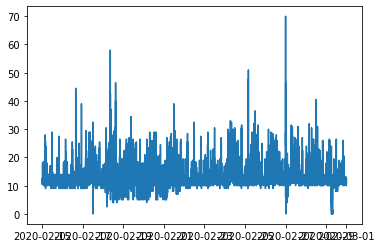

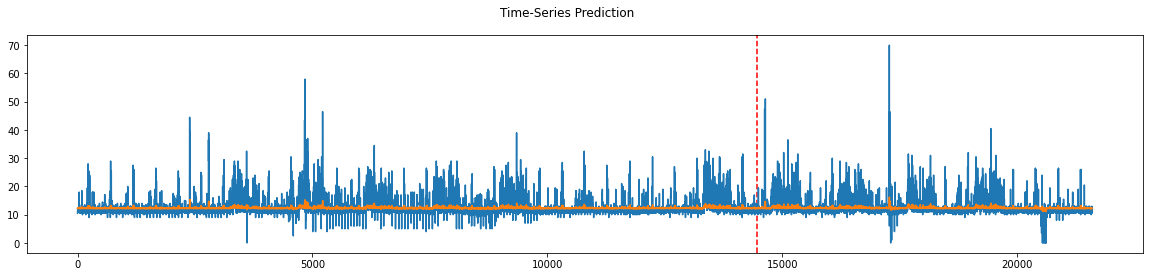

----- ND Results -----
LSTM
MAPE - 0.15728487074375153
MSE - 0.0017701841193528735
MSE - 0.0017701841193528735
RMSE - 0.04207355605784795
SMAPE - 0.0631878674030304
ABSOLUTE NAIVE
MAPE - 0.14948737991746525
MSE - 0.0024115678896842866
MSE - 0.0024115678896842866
RMSE - 0.049107717211088996
SMAPE - 0.06626395467104743
ABSOLUTE MEAN
MAPE - 0.1681886238146183
MSE - 0.0019353571129083114
MSE - 0.0019353571129083114
RMSE - 0.0439926938582796
SMAPE - 0.06720630760268399
SAMPLE NAIVE
MAPE - 0.12072613452246868
MSE - 0.001882994515383031
MSE - 0.001882994515383031
RMSE - 0.043393484711221696
SMAPE - 0.05685224713734397
SAMPLE MEAN
MAPE - 0.12446260097299937
MSE - 0.0015201054116575337
MSE - 0.0015201054116575337
RMSE - 0.038988529231782185
SMAPE - 0.056141960675574906


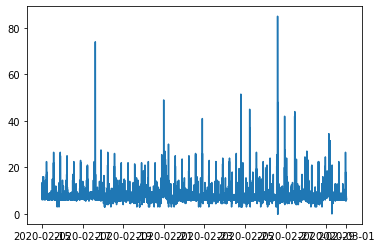

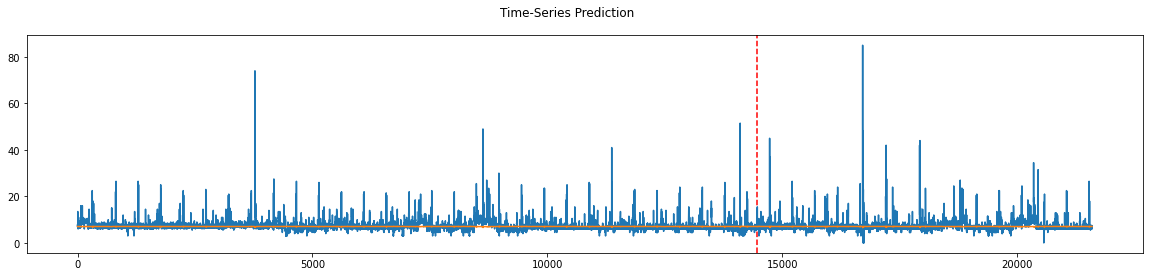

----- KY Results -----
LSTM
MAPE - 0.17047332227230072
MSE - 0.000881268129419675
MSE - 0.000881268129419675
RMSE - 0.029686160570536482
SMAPE - 0.08353804796934128
ABSOLUTE NAIVE
MAPE - 0.20692418434319704
MSE - 0.0009033924026933681
MSE - 0.0009033924026933681
RMSE - 0.030056486865456648
SMAPE - 0.09611098792767908
ABSOLUTE MEAN
MAPE - 0.17307225022561887
MSE - 0.0008739291476919654
MSE - 0.0008739291476919654
RMSE - 0.029562292666367496
SMAPE - 0.08428690479178458
SAMPLE NAIVE
MAPE - 0.12023780968053084
MSE - 0.0010194819734869924
MSE - 0.0010194819734869924
RMSE - 0.03192932779572712
SMAPE - 0.05676979648192548
SAMPLE MEAN
MAPE - 0.12397849199267011
MSE - 0.0007821370698697333
MSE - 0.0007821370698697333
RMSE - 0.027966713605100856
SMAPE - 0.05947523094316783


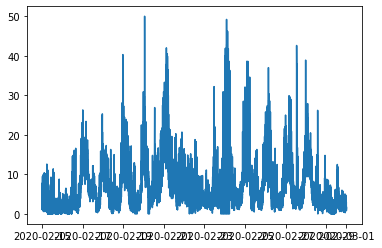

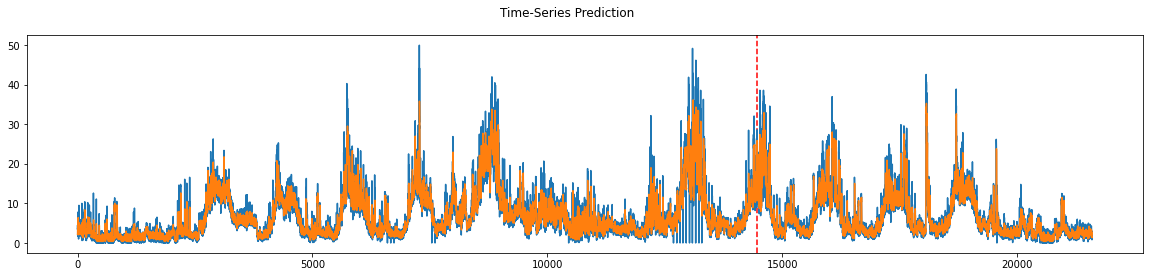

----- RI Results -----
LSTM
MAPE - 0.33246293663978577
MSE - 0.002296063179753682
MSE - 0.002296063179753682
RMSE - 0.04791725346630044
SMAPE - 0.1368827521800995
ABSOLUTE NAIVE
MAPE - 8.442109661059412
MSE - 0.17414890361426247
MSE - 0.17414890361426247
RMSE - 0.4173115186695216
SMAPE - 0.6499840552315134
ABSOLUTE MEAN
MAPE - 1.7027353981013265
MSE - 0.014649430264165585
MSE - 0.014649430264165585
RMSE - 0.12103483078918062
SMAPE - 0.36499047296834214
SAMPLE NAIVE
MAPE - 0.2783618202866052
MSE - 0.0023723754686354303
MSE - 0.0023723754686354303
RMSE - 0.04870703715722637
SMAPE - 0.12892244327402885
SAMPLE MEAN
MAPE - 0.31366496132010296
MSE - 0.002492101492617347
MSE - 0.002492101492617347
RMSE - 0.049920952441007645
SMAPE - 0.13976171640619317


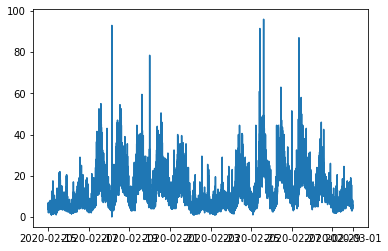

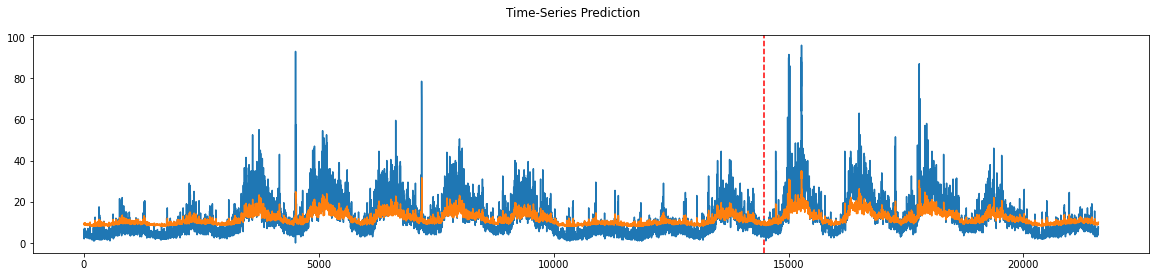

----- CA Results -----
LSTM
MAPE - 0.4134137034416199
MSE - 0.00560733575179966
MSE - 0.00560733575179966
RMSE - 0.07488214574783271
SMAPE - 0.17660868167877197
ABSOLUTE NAIVE
MAPE - 0.5732709813331428
MSE - 0.021058329231571377
MSE - 0.021058329231571377
RMSE - 0.14511488287412624
SMAPE - 0.4318131635914922
ABSOLUTE MEAN
MAPE - 0.583883343925168
MSE - 0.011370249375371372
MSE - 0.011370249375371372
RMSE - 0.10663137144091964
SMAPE - 0.2556430358208109
SAMPLE NAIVE
MAPE - 0.1950650913979204
MSE - 0.002078302622690634
MSE - 0.002078302622690634
RMSE - 0.045588404476255076
SMAPE - 0.09228322854687233
SAMPLE MEAN
MAPE - 0.21241673495123667
MSE - 0.0022532148460314805
MSE - 0.0022532148460314805
RMSE - 0.047468040259015125
SMAPE - 0.09945173583948036


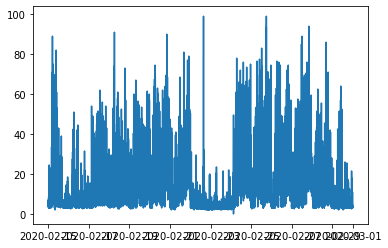

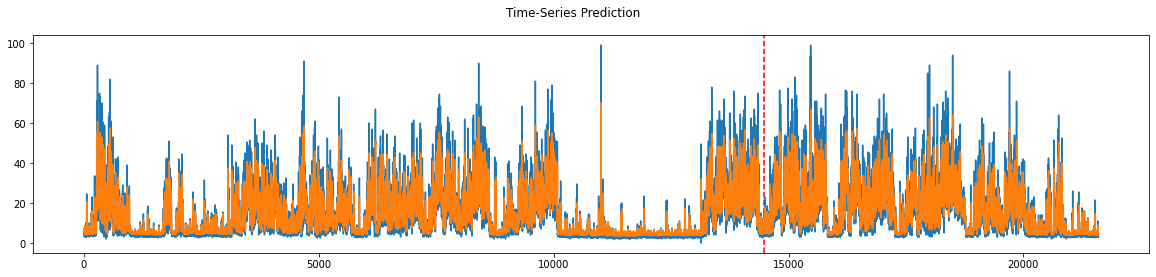

----- DE Results -----
LSTM
MAPE - 0.41575735807418823
MSE - 0.008030103670358156
MSE - 0.008030103670358156
RMSE - 0.08961084571835128
SMAPE - 0.1722082793712616
ABSOLUTE NAIVE
MAPE - 0.5840240391635654
MSE - 0.037110778912253166
MSE - 0.037110778912253166
RMSE - 0.19264158147257088
SMAPE - 0.467408605944826
ABSOLUTE MEAN
MAPE - 1.0093367376780251
MSE - 0.02089586589548573
MSE - 0.02089586589548573
RMSE - 0.1445540241414459
SMAPE - 0.3414154971309922
SAMPLE NAIVE
MAPE - 0.40664323980998984
MSE - 0.009976091861482884
MSE - 0.009976091861482884
RMSE - 0.09988038777198897
SMAPE - 0.17610715209184663
SAMPLE MEAN
MAPE - 0.4328411055992546
MSE - 0.009608949062464405
MSE - 0.009608949062464405
RMSE - 0.0980252470665818
SMAPE - 0.177896343210768


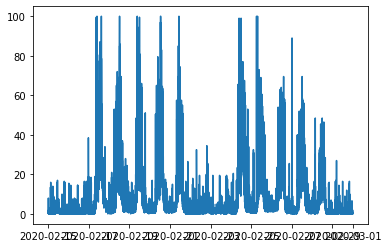

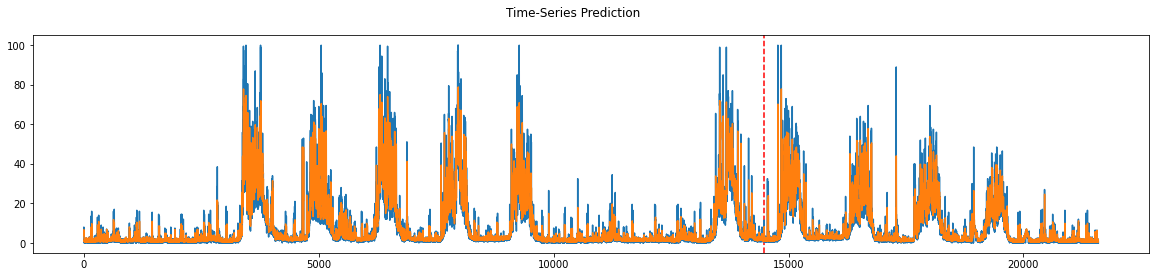

----- OK Results -----
LSTM
MAPE - 0.5820733308792114
MSE - 0.0029896197821492818
MSE - 0.0029896197821492818
RMSE - 0.054677415649875785
SMAPE - 0.2550848722457886
ABSOLUTE NAIVE
MAPE - 0.7228578262353116
MSE - 0.017440353206143802
MSE - 0.017440353206143802
RMSE - 0.13206192943518508
SMAPE - 0.48473192986710384
ABSOLUTE MEAN
MAPE - 4.09225755743794
MSE - 0.01359211148815558
MSE - 0.01359211148815558
RMSE - 0.11658521127551119
SMAPE - 0.5917637673759234
SAMPLE NAIVE
MAPE - 0.4952565693919218
MSE - 0.0032231295902136704
MSE - 0.0032231295902136704
RMSE - 0.056772613029643704
SMAPE - 0.25406091339421666
SAMPLE MEAN
MAPE - 0.53721224484147
MSE - 0.003658010085379722
MSE - 0.003658010085379722
RMSE - 0.06048148547596795
SMAPE - 0.2620236941296088


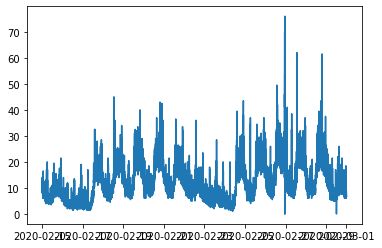

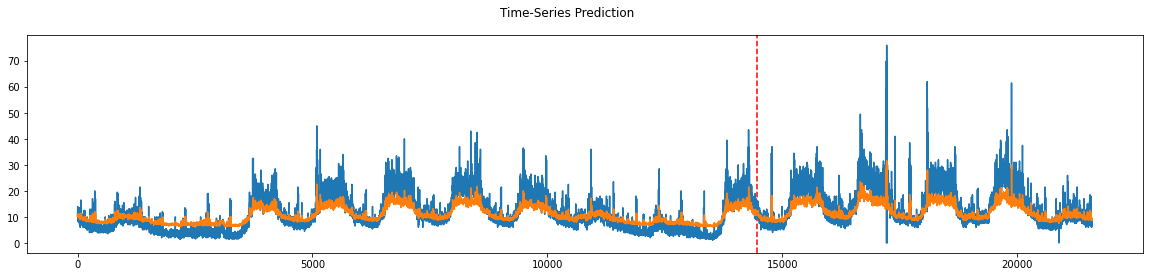

----- NE Results -----
LSTM
MAPE - 0.21687164902687073
MSE - 0.004638932539735283
MSE - 0.004638932539735283
RMSE - 0.06810970958486963
SMAPE - 0.11479399353265762
ABSOLUTE NAIVE
MAPE - 0.3740152296082865
MSE - 0.01214891408512089
MSE - 0.01214891408512089
RMSE - 0.11022211250525409
SMAPE - 0.20779928245824755
ABSOLUTE MEAN
MAPE - 0.3663899178940755
MSE - 0.012938884715674618
MSE - 0.012938884715674618
RMSE - 0.11374921852775349
SMAPE - 0.2122529090440454
SAMPLE NAIVE
MAPE - 0.15775075306518918
MSE - 0.0023361583937875035
MSE - 0.0023361583937875035
RMSE - 0.04833382246199346


KeyboardInterrupt: 

In [11]:
for state in listdir("samples/"):
    training_set = readData("samples/"+state)
    (dataX, dataY), (trainX, trainY), (testX, testY), train_size, sc = genData(training_set)
    naive_models = getNaive(trainY, testY, testX)
    lstm = train(trainX, trainY)
    data_predict, dataY_plot = test(lstm, dataX, dataY, train_size, sc)
    print("----- {} Results -----".format(state.replace(".csv", "")))
    forecasts = data_predict[train_size:]
    labels = dataY_plot[train_size:]
    
    print("LSTM")
    print_errors(forecasts, labels)
    naive_model_names = ["ABSOLUTE NAIVE", "ABSOLUTE MEAN", "SAMPLE NAIVE", "SAMPLE MEAN"]
    for (name, model) in zip(naive_model_names, naive_models):
        print(name)
        print_errors(model, labels)
    #printErrors(data_predict, dataY_plot, train_size, naive_forecasts, mean_forecasts, four_mean_forecasts, four_naive_forecasts)